# Week 1

# Imports

In [1]:
# 1. Standard Library Imports
import os
import csv

# 2. Third-Party Data & Visualization Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display

# 3. Gymnasium & ALE (Atari) Imports
import gymnasium as gym
import ale_py
from gymnasium import spaces

# 4. Stable Baselines3 Imports
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.monitor import Monitor


from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
import os

# Seleção do Ambiente: Assault


Para este trabalho de aprendizagem por reforço, foi escolhido o ambiente **Assault** da suite Atari disponível no Gymnasium. Assault é um jogo arcade clássico onde o agente controla um veículo na parte inferior do ecrã que deve destruir naves espaciais inimigas enquanto evita os seus projéteis. Este ambiente apresenta um desafio interessante para agentes de RL devido à sua natureza dinâmica, exigindo tanto **estratégias ofensivas** (destruir inimigos) como **manobras defensivas** (esquivar-se de ataques). O sistema de pontuação do jogo, os padrões de movimento dos inimigos e a mecânica dos projéteis oferecem múltiplas oportunidades para personalizações significativas que podem impactar substancialmente a aprendizagem e o desempenho do agente. Adicionalmente, o facto de a arma poder sofrer **overheat** caso o agente dispare continuamente torna-se um desafio particularmente interessante, obrigando o agente a equilibrar a agressividade com a **gestão de recursos e timing estratégico**. A complexidade visual e os requisitos de tomada de decisão em tempo real tornam-no um ambiente ideal para avaliar como as modificações ambientais afetam a capacidade do agente de desenvolver políticas eficazes.

In [2]:
# Verificação do Ambiente: Registo e Carregamento

# Regista os ambientes Atari (ALE) no Gymnasium
gym.register_envs(ale_py)

# Cria o ambiente Assault da suite Atari
env = gym.make("ALE/Assault-v5", render_mode="rgb_array")
print("Ambiente carregado com sucesso!")

Ambiente carregado com sucesso!


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


In [ ]:

env = gym.make("ALE/Assault-v5", render_mode="rgb_array")
obs, info = env.reset()

tamanho_janela = (400, 500) 

# --- CONFIGURAÇÃO DE VELOCIDADE ---
# 1 ms = super rápido (máximo do CPU)
# 16 ms = ~60 FPS (velocidade normal do jogo)
# 50 ms = ~20 FPS (câmara lenta)
delay_ms = 50 
# ----------------------------------

for step in range(2000):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    
    if obs is not None:
        imagem = cv2.cvtColor(obs, cv2.COLOR_RGB2BGR)
        imagem_redimensionada = cv2.resize(imagem, tamanho_janela, interpolation=cv2.INTER_NEAREST)
        
        cv2.imshow("Assault - Mais Lento", imagem_redimensionada)
        
        # AQUI ESTÁ A MUDANÇA: Usamos a variável 'delay_ms'
        if cv2.waitKey(delay_ms) & 0xFF == ord('q'):
            break

    if terminated or truncated:
        obs, info = env.reset()

env.close()
cv2.destroyAllWindows()

# só para ver quantos pontos ele ganha normalmente

## Implementação do Wrapper Personalizado

Para introduzir as modificações necessárias ao ambiente Assault, foi desenvolvido o **CustomAssaultWrapper**, uma classe que herda de `gym.Wrapper` e permite alterar o comportamento do ambiente original sem modificar diretamente o código base do Gymnasium. Este wrapper implementa três categorias principais de modificações que visam aumentar significativamente a complexidade e o realismo do desafio de aprendizagem. 

No **espaço de estados**, o wrapper converte as observações RGB originais (210×160×3) para **grayscale** (210×160×1), reduzindo a dimensionalidade da entrada e forçando o agente a aprender representações mais eficientes baseadas apenas em informação de luminância. Adicionalmente, é introduzido **ruído visual gaussiano** às observações, simulando condições imperfeitas de perceção e testando a robustez do agente a perturbações nos dados de entrada. Esta modificação é particularmente relevante para avaliar a capacidade de generalização do modelo em ambientes com informação visual ruidosa.

Na **estrutura de recompensas**, são implementadas três penalizações estratégicas que moldam o comportamento do agente: uma **living penalty** constante por frame (-0.01) que incentiva o agente a completar níveis mais rapidamente e evita comportamentos passivos; uma **shooting penalty** (-0.5) aplicada sempre que o agente dispara, forçando-o a desenvolver estratégias de tiro mais precisas e eficientes em vez de disparar continuamente; e uma **death penalty** severa (-100.0) aplicada quando o agente perde uma vida. Esta última penalização é particularmente crítica, pois com um valor aproximadamente cinco vezes superior à recompensa por eliminar um inimigo (+21), força o agente a priorizar a sobrevivência e desenvolver capacidades defensivas robustas. A implementação desta penalização requer o rastreamento interno do número de vidas através da variável `self.lives`, que é comparada a cada step com o valor atual retornado no dicionário `info`. Quando é detetada uma diminuição no número de vidas, a penalização é aplicada e o contador é atualizado. Esta combinação de penalizações cria um dilema multidimensional onde o agente deve equilibrar agressividade (maximizar kills), eficiência (minimizar tempo e disparos desperdiçados), e sobrevivência (evitar dano), tornando o processo de aprendizagem significativamente mais desafiante e próximo de cenários realistas onde a preservação do agente é prioritária.

In [3]:

class CustomAssaultWrapper(gym.Wrapper):
    """
    Wrapper Personalizado para Assault (Atari).
    
    Modificações:
    1. State Space (Visual): Grayscale + Ruído.
    2. Rewards:
       - Living Penalty: -0.01 por frame.
       - Shooting Penalty: -0.5 por tiro.
       - Death Penalty: Penalidade grande ao perder uma vida.
    """
    def __init__(self, env, noise_level=15, living_penalty=-0.01, shot_penalty=-0.5, death_penalty=-100.0):
        super().__init__(env)
        self.noise_level = noise_level
        self.living_penalty = living_penalty
        self.shot_penalty = shot_penalty
        self.death_penalty = death_penalty # <--- NOVO PARÂMETRO
        
        self.action_meanings = env.unwrapped.get_action_meanings()
        
        # Variável interna para rastrear vidas
        self.lives = 4
        
        # --- ATUALIZAÇÃO DO STATE SPACE ---
        old_shape = env.observation_space.shape
        new_shape = (old_shape[0], old_shape[1], 1)
        self.observation_space = spaces.Box(low=0, high=255, shape=new_shape, dtype=np.uint8)

    def _convert_to_grayscale(self, obs):
        gray = np.dot(obs[..., :3], [0.299, 0.587, 0.114])
        gray = np.expand_dims(gray, axis=-1)
        return gray.astype(np.uint8)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # --- CÁLCULO DAS REWARDS ---
        modified_reward = reward + self.living_penalty
        
        # 1. Penalidade de Tiro
        action_name = self.action_meanings[action]
        if "FIRE" in action_name:
            modified_reward += self.shot_penalty
            
        # 2. Penalidade de Morte (NOVO)
        # Verificamos quantas vidas temos AGORA
        current_lives = info.get("lives", 0)
        
        # Se as vidas diminuíram em relação ao passo anterior
        if current_lives < self.lives:
            modified_reward += self.death_penalty
            # Opcional: print para debug se quiseres ver acontecer
            # print(f"MORREU! Vidas: {self.lives} -> {current_lives}. Penalty: {self.death_penalty}")
        
        # Atualizamos o nosso contador de vidas para o próximo passo
        self.lives = current_lives
            
        # --- STATE SPACE ---
        gray_obs = self._convert_to_grayscale(obs)
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return noisy_obs, modified_reward, terminated, truncated, info

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        
        # Importante: Atualizar o contador de vidas no início do jogo
        self.lives = info.get("lives", 0)
        
        gray_obs = self._convert_to_grayscale(obs)
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return noisy_obs, info

In [4]:
# --- FUNÇÃO DE CRIAÇÃO E TESTE ---

def make_custom_env():
    """
    Cria e retorna tanto o ambiente original como o ambiente personalizado.
    
    Returns:
        env: Ambiente Assault original (sem modificações)
        custom_env: Ambiente Assault com wrapper personalizado aplicado
    """
    # Cria o ambiente base Assault com renderização RGB
    env = gym.make("ALE/Assault-v5", render_mode="rgb_array")
    
    # Aplica o wrapper personalizado com as modificações:
    # - noise_level=50: Nível de ruído gaussiano aplicado às observações grayscale
    #   (Nota: em grayscale o ruído é mais visível que em RGB, podendo obscurecer inimigos)
    # - living_penalty=-0.01: Penalidade constante por frame para incentivar eficiência
    # - shot_penalty=-0.5: Penalização por cada disparo para promover precisão
    custom_env = CustomAssaultWrapper(env, noise_level=50, living_penalty=-0.01, shot_penalty=-0.5,death_penalty=-100.0)
    
    return env, custom_env

Ambiente com Death Penalty configurado.
Original Space: (210, 160, 3)
Custom Space (Esperado H,W,1): (210, 160, 1)


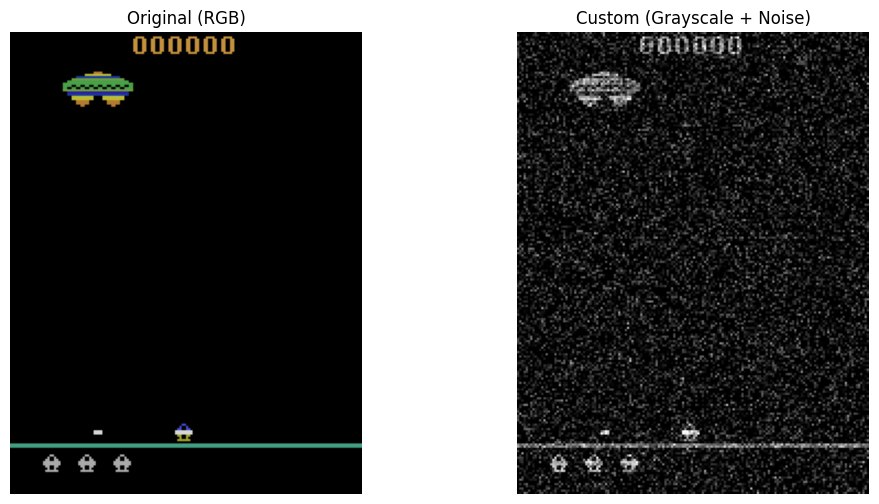

Simulação de Kill:
  Ganho Bruto: 21.0
  Custo (Tempo + Tiro): -0.51
  Lucro Líquido: 20.49 (Ainda compensa muito matar!)


In [5]:
# --- VALIDAÇÃO FINAL (Week 1) ---

original_env, custom_env = make_custom_env()
custom_env.reset()

print("Ambiente com Death Penalty configurado.")

'''# Vamos simular uma situação manualmente para testar a matemática
# Imagina que o agente estava a jogar e tinha 4 vidas
custom_env.lives = 4 

# Agora damos um passo e fingimos que o emulador diz que só temos 3 vidas
# (Nota: não consigo forçar o emulador a matar o agente facilmente, 
# por isso vou criar um passo 'falso' só para testar a tua classe)

print("\n--- Simulação de Morte ---")
print(f"Vidas antes: {custom_env.lives}")

# Passo fictício onde o info diz que vidas baixaram para 3
# Vamos assumir que ele não matou ninguém (reward base 0) e não disparou
fake_info = {"lives": 3} 
reward_base = 0.0

# Calcular manualmente o que o teu wrapper faria:
r_mod = reward_base - 0.01 # Living penalty
if 3 < 4: # Perdeu vida
    r_mod += -100.0 # Death penalty

print(f"Vidas depois (info): {fake_info['lives']}")
print(f"Reward Calculada: {r_mod}")

if r_mod <= -100:
    print("SUCESSO: A penalidade de morte foi aplicada corretamente!")
else:
    print("ERRO: Algo falhou na lógica.")

original_env.close()
custom_env.close()'''

print(f"Original Space: {original_env.observation_space.shape}")
print(f"Custom Space (Esperado H,W,1): {custom_env.observation_space.shape}")

# 1. Teste Visual
obs_orig, _ = original_env.reset()
obs_custom, _ = custom_env.reset()

# Como o custom agora é (210, 160, 1), temos de remover a dimensão 1 
# para o matplotlib desenhar (ele quer H, W). Usamos .squeeze()
obs_custom_plot = obs_custom.squeeze() 

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(obs_orig)
ax[0].set_title("Original (RGB)")
ax[0].axis("off")

# cmap='gray' diz ao python para desenhar em tons de cinza
ax[1].imshow(obs_custom_plot, cmap='gray', vmin=0, vmax=255) 
ax[1].set_title("Custom (Grayscale + Noise)")
ax[1].axis("off")

plt.show()

# 2. Teste Rápido de Reward (Só para confirmar valores)
_, r_kill, _, _, _ = original_env.step(0) 
# Vamos fingir que matamos alguém alterando manualmente o reward para testar a tua teoria
# Se reward base fosse 21...
r_base = 21.0
r_final = r_base - 0.01 - 0.5 # Matou (+21), viveu (-0.01), disparou (-0.5)
print(f"Simulação de Kill:")
print(f"  Ganho Bruto: {r_base}")
print(f"  Custo (Tempo + Tiro): -0.51")
print(f"  Lucro Líquido: {r_final:.2f} (Ainda compensa muito matar!)")

original_env.close()
custom_env.close()


## Resultado Observado:

Espaço de Estados: 
- Confirmado que o wrapper reduziu a dimensionalidade de (210, 160, 3) para (210, 160, 1), com conversão bem-sucedida para grayscale

Ruído Visual: 
- Como visível na imagem da direita, o ruído gaussiano (noise_level=50) adiciona uma granulação significativa que torna a deteção de objetos mais desafiante, testando a robustez do agente

Estrutura de Rewards: 
- A simulação confirma que, mesmo com as penalizações, matar inimigos continua altamente recompensador (+20.49 líquido), mas as penalizações acumuladas ao longo de milhares de frames incentivam eficiência temporal e precisão de tiro
- Confirmação de que perante morte do agente ocorre uma penalização

# Week 2


# Seleção e Implementação do Algoritmo: Proximal Policy Optimization (PPO)

Para o treino do agente no ambiente Assault customizado, foi selecionado o algoritmo **Proximal Policy Optimization (PPO)**, disponível na biblioteca Stable-Baselines3. O PPO é um algoritmo de aprendizagem por reforço baseado em policy gradient que se tornou um dos métodos mais populares e eficazes para treinar agentes em ambientes complexos, tendo sido desenvolvido pela OpenAI em 2017. Este algoritmo pertence à família dos métodos **on-policy**, onde o agente aprende diretamente a partir das suas próprias experiências recentes, atualizando iterativamente a sua política de ação.

A **escolha do PPO** para o ambiente Assault justifica-se por várias razões fundamentais. Primeiro, o PPO demonstra excelente **estabilidade e robustez** durante o treino, características essenciais quando se trabalha com ambientes visuais complexos e com múltiplas modificações como as implementadas no nosso wrapper (grayscale, ruído, e estrutura de penalizações complexa). Ao contrário de algoritmos como o TRPO (Trust Region Policy Optimization) que requerem cálculos de segunda ordem computacionalmente caros, o PPO mantém a estabilidade através de um mecanismo de **clipping** simples mas eficaz, que limita a magnitude das atualizações da política. Isto previne atualizações destrutivas que poderiam fazer o agente "esquecer" comportamentos úteis já aprendidos, problema particularmente crítico em ambientes Atari onde o espaço de estados é enorme.

Segundo, o PPO é especialmente adequado para **ambientes visuais de alta dimensionalidade** como o Assault, onde as observações são imagens de 210×160 pixels. A implementação utiliza a **CnnPolicy**, uma política baseada em redes neuronais convolucionais (CNNs) que são arquiteturas especializadas para processar dados visuais. As CNNs conseguem extrair automaticamente features hierárquicas das imagens - desde bordas e texturas nos primeiros layers até representações semânticas de objetos (inimigos, projéteis, o próprio jogador) nos layers mais profundos. Esta capacidade de extração automática de features é crucial num ambiente como o Assault onde o agente precisa de identificar múltiplos objetos em movimento simultâneo e tomar decisões em tempo real.

Terceiro, o PPO destaca-se pela sua **versatilidade e capacidade de generalização** em domínios diversos. O mesmo algoritmo, com ajustes mínimos, tem demonstrado sucesso desde jogos Atari a controlo robótico e até ambientes multi-agente. Esta robustez cross-domain aumenta a confiança de que o algoritmo conseguirá lidar eficazmente com as particularidades do ambiente Assault customizado, incluindo o ruído visual adversarial e a estrutura de recompensas complexa com múltiplas penalizações concorrentes (living penalty, shooting penalty, e death penalty). O facto de o PPO ser amplamente adotado pela comunidade também significa excelente documentação, debugging facilitado, e benchmarks estabelecidos para comparação de resultados, tornando-o uma escolha sólida e bem fundamentada para este projeto de aprendizagem por reforço.

Criação dos Logs

In [6]:
LOG_DIR = "./assault_logs/"
os.makedirs(LOG_DIR, exist_ok=True)
MODEL_NAME_BASE = "ppo_custom_assault_base" # Nome do ficheiro
MODEL_PATH_BASE = os.path.join(LOG_DIR, f"{MODEL_NAME_BASE}.zip")

MODEL_NAME_MOD = "ppo_custom_assault_mod"  # Nome do ficheiro modificado
MODEL_PATH_MOD = os.path.join(LOG_DIR, f"{MODEL_NAME_MOD}.zip")

## Hiper Parâmetros 

## Configuração de Hiperparâmetros do PPO

A configuração do algoritmo PPO requer a definição de diversos hiperparâmetros que controlam diferentes aspetos do processo de aprendizagem. O **learning_rate** (taxa de aprendizagem) determina a magnitude dos ajustes aos pesos da rede neural em cada atualização, equilibrando velocidade e estabilidade do treino. O **n_steps** define quantos passos de interação com o ambiente são coletados antes de realizar uma atualização da *policy*, enquanto o **batch_size** especifica o tamanho dos mini-batches utilizados durante a otimização.

O **ent_coef** (coeficiente de entropia) penaliza políticas demasiado determinísticas, promovendo a exploração do ambiente e evitando convergência prematura para estratégias subótimas. O **gamma** (fator de desconto) determina quanto o agente valoriza recompensas futuras versus imediatas, sendo crucial para incentivar planeamento a longo prazo. O **clip_range** é o mecanismo central do PPO que limita mudanças drásticas na política entre atualizações, garantindo estabilidade e prevenindo colapsos de desempenho. Finalmente, o **total_timesteps** especifica o número total de interações ambiente-agente durante a sessão de treino.

In [7]:
N_ENVS = 2

In [8]:
# Hiperparâmetros iniciais (Base)
params_base = {
    "learning_rate": 2.5e-4, # Fixo
    "n_steps": 2048 * N_ENVS,
    "batch_size": 256,
    "ent_coef": 0.01,
    "gamma": 0.99,           # Valor padrão do SB3
    "clip_range": 0.2,       # Valor padrão do SB3
    "total_timesteps": 1000 
}

params_mod = {

}

## Preparação do Ambiente: Frame Stacking

Uma técnica fundamental implementada na preparação do ambiente de treino é o **Frame Stacking**, aplicado através do wrapper `VecFrameStack` com `n_stack=4`. Esta técnica consiste em empilhar 4 frames consecutivos do jogo, transformando a observação final de uma única imagem grayscale (1, 210, 160) numa sequência temporal de 4 imagens (4, 210, 160). Esta modificação é crucial porque uma imagem estática isolada não contém informação sobre movimento ou direção, isto é o agente não consegue determinar se um projétil está a aproximar-se ou a afastar-se, nem a velocidade dos inimigos, apenas observando um único frame.

Ao empilhar 4 frames consecutivos, o agente ganha **informação temporal implícita** que lhe permite inferir velocidades e trajetórias. Por exemplo, observando a posição de um projétil inimigo em 4 frames sequenciais, a rede neural pode calcular a sua direção e velocidade de movimento, permitindo antecipar onde estará no próximo frame e tomar decisões defensivas apropriadas. Esta capacidade é absolutamente essencial no Assault, onde a sobrevivência depende de esquivar projéteis em movimento rápido e prever os padrões de ataque dos inimigos.

A escolha de empilhar frames torna-se particularmente **eficiente no contexto grayscale**. Como cada frame tem apenas 1 canal de cor em vez de 3 (RGB), empilhar 4 frames resulta em apenas 4 canais totais, comparável aos 3 canais de uma única imagem RGB original. Isto significa que o custo computacional adicional é mínimo, mas os benefícios são substanciais, o agente efetivamente ganha "visão temporal" sem sobrecarregar significativamente a memória ou o processamento da CNN. Esta técnica de frame stacking é uma prática standard em aprendizagem por reforço para jogos Atari, sendo frequentemente considerada essencial para alcançar desempenho competente em ambientes que requerem compreensão de dinâmicas temporais.

In [9]:
# 2. Função para instanciar o ambiente de treino
def make_training_env(rank, seed):
    """
    Função utilitária para criar ambientes para o SubprocVecEnv.
    :param rank: Indice do sub-processo (0, 1, 2, ...)
    :param seed: Seed aleatória global
    """
    def _init():
        import ale_py
        import shimmy
        env = gym.make("ALE/Assault-v5")
        
        # Aplica o teu Wrapper customizado
        env = CustomAssaultWrapper(env, noise_level=15, living_penalty=-0.01, shot_penalty=-0.5, death_penalty=-100.0)
        
        # Configura a seed para este ambiente específico (importante para variedade)
        env.reset(seed=seed + rank)
        
        # Monitor: Cria um ficheiro único para cada env (ex: monitor_0.csv, monitor_1.csv)
        log_file = os.path.join(LOG_DIR, str(rank))
        env = Monitor(env, log_file)
        return env

    set_random_seed(seed)
    return _init

if __name__ == '__main__':
    # Cria os 8 processos separados
    vec_env = SubprocVecEnv([make_training_env(i, 42) for i in range(N_ENVS)])

    # APLICAÇÃO DO FRAME STACKING
    # Como estamos em Grayscale, empilhar 4 frames é barato e dá noção de movimento.
    # O input final para a rede será (4, 210, 160) - 4 canais de cinzento.
    vec_env = VecFrameStack(vec_env, n_stack=4)

    print("Ambiente preparado com Frame Stack (4 frames).")
    print(f"Observation Space Final: {vec_env.observation_space.shape}")
    # O shape será (8, 4, 210, 160) se usares batch_size no treino, 
    # mas o obs space reportado continua a ser (4, 210, 160) por ambiente.

Ambiente preparado com Frame Stack (4 frames).
Observation Space Final: (210, 160, 4)


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


## Load ou Criação de novos Dados

Verifica se já existe este modelo, se não cria um novo, se sim dá load.
> Na proxima celula trocar para modelo base ou modificado dependendo da necessidade

In [10]:
MODEL_NAME = MODEL_NAME_BASE
MODEL_PATH = MODEL_PATH_BASE
params = params_base
CSV_FILE = "data/avaliacao_base_log.csv"

In [11]:
os.makedirs("data", exist_ok=True)

In [12]:
# --- LÓGICA DE CONTINUAÇÃO (LOAD vs NEW) ---

if os.path.exists(MODEL_PATH):
    print(f"Encontrado modelo existente: {MODEL_NAME}")
    print("A carregar pesos e a continuar o treino...")
    
    # Carrega o modelo e liga-o ao ambiente atual
    model = PPO.load(MODEL_PATH, env=vec_env)
    
    # Para continuar os gráficos no sítio certo, não resetamos os timesteps
    reset_timesteps = False 

else:
    # 4. Criação do Agente PPO
    # Policy 'CnnPolicy' é obrigatória porque a entrada são imagens (pixels)
    print(f"Nenhum modelo encontrado com o nome: {MODEL_NAME}")
    print("A criar um novo agente do zero...")
    
    model = PPO(
        "CnnPolicy", 
        vec_env, 
        verbose=0,

        # Aqui passamos os novos hiperparâmetros
        learning_rate=params["learning_rate"],
        n_steps=params["n_steps"],
        batch_size=params["batch_size"],
        ent_coef=params["ent_coef"],
        gamma=params["gamma"],
        clip_range=params["clip_range"],
        tensorboard_log=LOG_DIR
    )
    reset_timesteps = True

Nenhum modelo encontrado com o nome: ppo_custom_assault_base
A criar um novo agente do zero...


# Guardar dados

In [13]:
def evaluate_and_log_to_csv(model_zip_path, csv_file, n_eval_episodes=50):
    
    if not os.path.exists(model_zip_path):
        print(f"ERRO: Ficheiro {model_zip_path} não encontrado.")
        return

    print(f"--- A carregar modelo: {model_zip_path} ---")
    
    # Criar Ambiente de Avaliação
    def make_eval_env():
        env = gym.make("ALE/Assault-v5", render_mode=None)
        env = Monitor(env) # Monitor para Score Real
        env = CustomAssaultWrapper(env, noise_level=15, living_penalty=-0.01, shot_penalty=-0.5, death_penalty=-100.0)
        return env

    eval_env = DummyVecEnv([make_eval_env]) 
    eval_env = VecFrameStack(eval_env, n_stack=4)

    # Carregar Modelo
    model = PPO.load(model_zip_path, env=eval_env)
    trained_timesteps = model.num_timesteps
    
    print(f"A iniciar avaliação de {n_eval_episodes} episódios...")

    # Listas para guardar métricas
    real_scores = []       
    agent_rewards = []     
    survival_times = []    

    for _ in range(n_eval_episodes):
        obs = eval_env.reset()
        done = False
        ep_agent_reward = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done_array, info_array = eval_env.step(action)
            
            done = done_array[0]
            reward_val = reward[0]
            info = info_array[0]
            
            ep_agent_reward += reward_val
            
            if done:
                if 'episode' in info:
                    real_scores.append(info['episode']['r'])
                    survival_times.append(info['episode']['l'])
                agent_rewards.append(ep_agent_reward)

    # --- CÁLCULOS ESTATÍSTICOS ---
    avg_score = np.mean(real_scores)
    avg_reward = np.mean(agent_rewards)
    std_reward = np.std(agent_rewards)  # Desvio Padrão do Reward
    avg_survival = np.mean(survival_times)

    print(f"Avaliação Concluída (Timesteps: {trained_timesteps}):")
    print(f"  > Score Jogo (Médio): {avg_score:.2f}")
    print(f"  > Reward Agente: {avg_reward:.2f} +/- {std_reward:.2f} (Std)")
    print(f"  > Sobrevivência Média: {avg_survival:.1f} frames")

    # --- GUARDAR NO CSV ---
    file_exists = os.path.isfile(csv_file)
    
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        
        # Cabeçalho atualizado com 'Std_Agent_Reward'
        if not file_exists:
            writer.writerow([
                "Training_Timesteps", 
                "Avg_Game_Score", 
                "Avg_Agent_Reward", 
                "Std_Agent_Reward", 
                "Avg_Survival"
            ])
            
        # Escrever linha
        writer.writerow([
            trained_timesteps, 
            avg_score, 
            avg_reward, 
            std_reward, 
            avg_survival
        ])
        
    print(f"Dados guardados em: {csv_file}\n")
    eval_env.close()

## Início de treino save dos Dados

> Trocar para o numero de iterações que desejar fazer

In [14]:
N = 2 # Número de iterações de treino

In [15]:
print(params)

{'learning_rate': 0.00025, 'n_steps': 4096, 'batch_size': 256, 'ent_coef': 0.01, 'gamma': 0.99, 'clip_range': 0.2, 'total_timesteps': 1000}


In [16]:
for _ in range(N):  
    if os.path.exists(MODEL_PATH):
        reset_timesteps = False 
    else:
        reset_timesteps = True    
    
    # --- TREINO ---
    print(f"A treinar por mais {params['total_timesteps']} passos...")

    # reset_num_timesteps=False é o segredo para os gráficos continuarem bonitos
    model.learn(total_timesteps=params["total_timesteps"], progress_bar=True, reset_num_timesteps=reset_timesteps)

    # --- GUARDAR ---
    model.save(MODEL_PATH)
    print("Treino concluído e modelo guardado/atualizado!")

    evaluate_and_log_to_csv(MODEL_PATH, CSV_FILE, n_eval_episodes=20)

Output()

A treinar por mais 1000 passos...


Treino concluído e modelo guardado/atualizado!
--- A carregar modelo: ./assault_logs/ppo_custom_assault_base.zip ---
A iniciar avaliação de 20 episódios...


Output()

Avaliação Concluída (Timesteps: 8192):
  > Score Jogo (Médio): 574.35
  > Reward Agente: 71.47 +/- 81.96 (Std)
  > Sobrevivência Média: 1018.0 frames
Dados guardados em: data/avaliacao_base_log.csv

A treinar por mais 1000 passos...


Treino concluído e modelo guardado/atualizado!
--- A carregar modelo: ./assault_logs/ppo_custom_assault_base.zip ---
A iniciar avaliação de 20 episódios...
Avaliação Concluída (Timesteps: 16384):
  > Score Jogo (Médio): 543.90
  > Reward Agente: 13.30 +/- 101.07 (Std)
  > Sobrevivência Média: 1170.2 frames
Dados guardados em: data/avaliacao_base_log.csv



# Visualização do Modelo

Após o treino do agente PPO, foi implementado um sistema de avaliação visual que permite observar o comportamento aprendido em ação. O código carrega o modelo treinado previamente guardado e recria o ambiente de avaliação com exatamente as mesmas configurações utilizadas durante o treino. 

A carregar o modelo: ./assault_logs/ppo_custom_assault_v1.zip
A gravar o jogo...
A guardar 1000 frames em assault_agent_gameplay.gif...
Aqui está o teu agente a jogar:


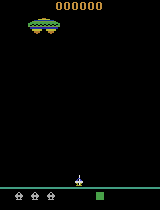

In [ ]:
# 1. Configurações
MODEL_PATH = "./assault_logs/ppo_custom_assault_v1.zip"
VIDEO_NAME = "assault_agent_gameplay.gif"
FRAMES_TO_RECORD = 1000  # Quantos frames queres gravar (aprox 30-40 segundos)

# 2. Recriar o Ambiente (TEM DE SER IGUAL AO DE TREINO)
def make_eval_env():
    env = gym.make("ALE/Assault-v5", render_mode="rgb_array")
    # Usa os mesmos parâmetros do Wrapper!
    env = CustomAssaultWrapper(env, noise_level=15, living_penalty=-0.01, shot_penalty=-0.5,death_penalty=-100.0)
    return env

# Vectorizar e Empilhar (Igual ao treino)
eval_env = DummyVecEnv([make_eval_env])
eval_env = VecFrameStack(eval_env, n_stack=4)

# 3. Carregar o Agente Treinado
if os.path.exists(MODEL_PATH):
    print(f"A carregar o modelo: {MODEL_PATH}")
    model = PPO.load(MODEL_PATH)
else:
    print("ERRO: Modelo não encontrado! Treina o agente primeiro.")
    # Parar execução se não houver modelo
    raise FileNotFoundError("Modelo não encontrado")

# 4. Loop de Jogo (Gravação)
print("A gravar o jogo...")
images = []
obs = eval_env.reset()

for i in range(FRAMES_TO_RECORD):
    # O modelo prevê a ação. 
    # deterministic=False dá variedade. deterministic=True joga 'a sério' (melhor performance).
    action, _ = model.predict(obs, deterministic=False)
    
    # Executar passo
    obs, rewards, dones, info = eval_env.step(action)
    
    # Capturar a imagem REAL do jogo (render)
    # Nota: O env.render() devolve a imagem original (RGB), que é mais bonita para vermos
    img = eval_env.render() 
    images.append(img)
    
    # Se o jogo acabar (perdeu todas as vidas), faz reset automático,
    # mas o nosso loop continua até completar os 1000 frames.

eval_env.close()

# 5. Salvar como GIF
print(f"A guardar {len(images)} frames em {VIDEO_NAME}...")
imageio.mimsave(VIDEO_NAME, images, fps=30) # 30 FPS é uma velocidade boa

# 6. Mostrar no Notebook
print("Aqui está o teu agente a jogar:")
display(Image(filename=VIDEO_NAME))